# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

---

## Executive Summary

### Business Problem
Megaline's commercial department needs to determine which prepaid plan (Surf or Ultimate) generates higher revenue to optimize their 2018 advertising budget allocation. Analysis of 500 customer accounts across calls, messages, and internet usage will identify the more profitable plan.

### Approach
- **Data Integration**: Cleaned and merged datasets containing 137K+ call records, 104K+ internet sessions, and 76K+ messages
- **Revenue Modeling**: Engineered revenue calculations incorporating plan-specific overage charges
- **Statistical Testing**: Used Welch's t-test to compare average revenue between plans
- **Regional Analysis**: Tested whether NY-NJ area shows different revenue patterns than other markets

### Key Findings

**Plan Performance:**

| Metric | Surf Plan | Ultimate Plan | Difference |
|--------|-----------|---------------|------------|
| **Average Monthly Revenue** | $60.17 | **$72.25** | +20% |
| **Revenue Variance** | Higher | Lower | More predictable |
| **Statistical Significance** | - | p < 0.001 | Highly significant |

**Regional Analysis:**
- NY-NJ area vs other markets: **No significant difference** (p = 0.079)
- Revenue patterns consistent across geographic regions
- Geographic targeting NOT recommended

### Recommendations

**Advertising Strategy for 2018:**

1. **Prioritize Ultimate Plan**: 20% higher average revenue ($72.25 vs $60.17) with statistical confidence (p<0.001)

2. **Budget Allocation**: 
   - 70% of advertising budget → Ultimate plan
   - 30% of advertising budget → Surf plan (entry-level customer acquisition)

3. **Geographic Strategy**: Use national campaigns (no regional targeting needed)

4. **Customer Migration**: Develop upgrade campaigns to move Surf customers to Ultimate

**Expected Impact**: 20% increase in average revenue per user by shifting plan mix toward Ultimate

---


[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')


## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

In [3]:
# Exploring the data 

# Dataset previews
calls.head()

internet.head()

messages.head()

plans.head()

users.head()


# Dataset info
calls.info()

internet.info()

messages.info()

plans.info()

users.info()

# Dataset shapes
print("Calls shape:", calls.shape)

print("Internet shape:", internet.shape)

print("Messages shape:", messages.shape)

print("Plans shape:", plans.shape)

print("Users shape:", users.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dty

In [4]:
# Correcting errors: Converting date columns to datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])

internet['session_date'] = pd.to_datetime(internet['session_date'])

messages['message_date'] = pd.to_datetime(messages['message_date'])

#Checking conversion

calls.info()
internet.info()
messages.info()

# Found error in calls 
((calls['duration'] == 0.0).sum())

# Fix: Round 0.0 minute calls up to 1.0 minute per business rules
calls.loc[calls['duration'] < 1.0, 'duration'] = 1.0

calls['duration'].min()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
<class 'pandas.core.fram

1.0

## Plans

In [5]:
# Print the general/summary information about the plans' DataFrame
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [6]:
# Print a sample of data for plans
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

The plans dataset contains only two rows, denoting the two available plans: Surf and Ultimate. There are eight columns denoting the different features of each plan and the cost. There are no missing values, and all data types are appropriate. No additional cleaning or data typing is needed.

## Fix data

[Fix obvious issues with the data given the initial observations.]

## Enrich data

[Add additional factors to the data if you believe they might be useful.]

## Users

In [7]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Print a sample of data for users
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

The users dataset contains 500 rows and eight columns denoting the users' general information (e.g., name, city, and plan). There are missing values (i.e., NaN) for the churn date, which is appropriate, since the calling plan was in use when the database was extracted according to business instructions. All data types are appropriate. Hence, no additional cleaning or data typing is needed.

### Fix Data

[Fix obvious issues with the data given the initial observations.]

### Enrich Data

[Add additional factors to the data if you believe they might be useful.]

## Calls

In [9]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [10]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

The calls dataset has four columns. The call_date column was changed to a datetime data type in an earlier step. However, the duration should be rounded up to the next whole number, using math.ceil, as per the business instructions. Finally, the datatype for duration should be changed from a float to an integer.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [11]:
# Rounding the call duration up
import math
calls['duration'] = calls['duration'].apply(math.ceil)

#Changing data type
calls['duration'] = calls['duration'].astype(int)


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

## Messages

In [12]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [13]:
# Print a sample of data for messages
messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

The messages dataset has three columns. The message_date column was changed to a datetime data type in an earlier step. All data types are appropriate. Hence, no additional cleaning or data typing is needed.

### Fix data

[Fix obvious issues with the data given the initial observations.]

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

## Internet

In [14]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [15]:
# Print a sample of data for the internet traffic
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

The internet dataset has four columns. The session_date column was changed to a datetime data type in an earlier step. However, per the business instructions, individual web traffic sessions will not be rounded here. Therefore, no additional changes or cleaning were needed.

### Fix data

[Fix obvious issues with the data given the initial observations.]

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [16]:
# Print out the plan conditions and make sure they are clear for you
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [17]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls.groupby([calls['user_id'], calls['call_date'].dt.to_period('M')])['id'].count().reset_index()

# Renaming column id to total_calls for clarity
calls_per_month = calls_per_month.rename(columns={'id' : 'total_calls'})


In [18]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_month = calls.groupby([calls['user_id'], calls['call_date'].dt.to_period('M')])['duration'].sum().reset_index()

# Renaming duration to total_mins for clarity
minutes_per_month = minutes_per_month.rename(columns={'duration' : 'total_mins'})


In [19]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = messages.groupby([messages['user_id'], messages['message_date'].dt.to_period('M')])['id'].count().reset_index()

# Renaming id to total_messages for clarity
messages_per_month = messages_per_month.rename(columns={'id' : 'total_messages'})


In [20]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_month = internet.groupby([internet['user_id'], internet['session_date'].dt.to_period('M')])['mb_used'].sum().reset_index()

# Renaming mb_used to total volume for clarity
internet_per_month = internet_per_month.rename(columns={'mb_used' : 'total_volume'})


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [21]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
calls_per_month = calls_per_month.rename(columns={'call_date': 'month'})
minutes_per_month = minutes_per_month.rename(columns={'call_date': 'month'})
messages_per_month = messages_per_month.rename(columns={'message_date': 'month'})
internet_per_month = internet_per_month.rename(columns={'session_date': 'month'})

# Merging into one database
calls_per_month = calls_per_month.merge(minutes_per_month, on=['user_id', 'month'], how='outer')
calls_per_month = calls_per_month.merge(messages_per_month, on=['user_id', 'month'], how='outer')
calls_per_month = calls_per_month.merge(internet_per_month, on=['user_id', 'month'], how='outer')




In [22]:
# Add the plan information
calls_per_month = calls_per_month.merge(users[['user_id', 'plan']], on='user_id', how='left')
calls_per_month = calls_per_month.merge(plans, left_on='plan', right_on='plan_name', how='left')



[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [23]:

# Calculate the monthly revenue for each user
import numpy as np
calls_per_month['minutes_overage'] = np.maximum(0, calls_per_month['total_mins'] - calls_per_month['minutes_included']) * calls_per_month['usd_per_minute']

# Monthly revenue by messages
calls_per_month['message_overage'] = np.maximum(0, calls_per_month['total_messages'] - calls_per_month['messages_included']) * calls_per_month['usd_per_message']

# Monthly revenue by Internet
mb_overage = calls_per_month['total_volume'] - calls_per_month['mb_per_month_included']

# Round up GB if overage only
gb_overage = np.where(mb_overage > 0, np.ceil(mb_overage / 1024), 0)

# Calculate usage cost
calls_per_month['data_overage'] = gb_overage * calls_per_month['usd_per_gb']

# Calculate total monthly revenue
calls_per_month['total_revenue'] = calls_per_month['usd_monthly_pay'] + calls_per_month['minutes_overage'] + calls_per_month['message_overage'] + calls_per_month['data_overage']


## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

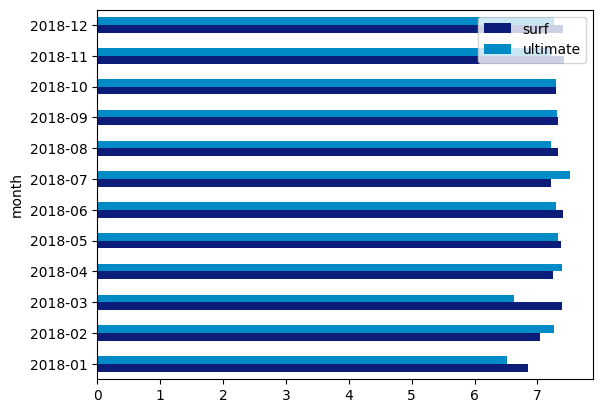

In [24]:

# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
calls_per_month['avg_call_duration'] = calls_per_month['total_mins'] / calls_per_month['total_calls']

# Group by plan and month for plan averages
call_duration_by_plan = calls_per_month.groupby(['plan_name', 'month'])['avg_call_duration'].mean()

# Reshape data for side-by-side plotting
call_duration_unstacked = call_duration_by_plan.unstack()

# Flip rows and columns
call_duration_transposed = call_duration_unstacked.T

# Creating bar plot
call_duration_transposed.plot(kind='barh', color=['#0b1d78', '#008ac6'])
plt.legend(loc='upper right')
plt.show()


This visualization shows that both Surf and Ultimate plans have very similar call duration patterns across all months, with averages consistently between 6.5 and 7.5 minutes per call. The month-to-month changes seem random rather than reflecting any systematic differences between plans. This indicates that plan choice does not affect how long users talk during individual calls, meaning calling behavior is independent of the plan's pricing or included minutes. This interpretation highlights that, despite different plan features, users' basic calling habits stay consistent - which is important for understanding that the revenue differences observed later are not caused by different calling patterns but by other factors, such as overage charges.

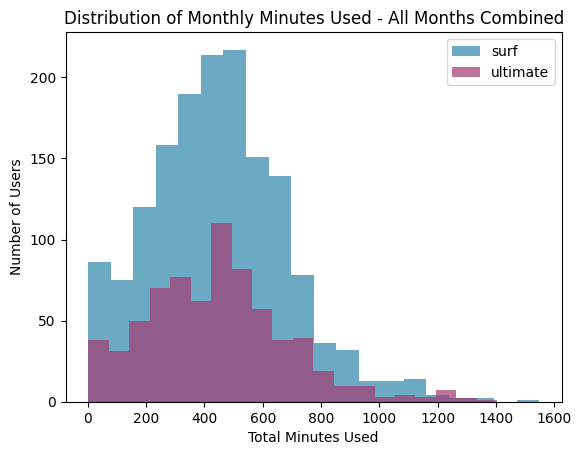

In [25]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
# Get all Surf users across all months
all_surf = calls_per_month[calls_per_month['plan_name'] == 'surf'] 

# Get all Ultimate users across all months
all_ultimate = calls_per_month[calls_per_month['plan_name'] == 'ultimate']

# Create histogram comparison
plt.hist(all_surf['total_mins'], bins=20, alpha=0.7, label='surf', color='#2E86AB')
plt.hist(all_ultimate['total_mins'], bins=20, alpha=0.7, label='ultimate', color='#A23B72')
plt.xlabel('Total Minutes Used')
plt.ylabel('Number of Users')
plt.title('Distribution of Monthly Minutes Used - All Months Combined')
plt.legend()
plt.show()

This histogram illustrates the differences in usage patterns between the two plans. Surf users (blue) mostly use between 400 and 600 minutes, showing a predictable, narrow calling pattern. In contrast, Ultimate users (purple) have a more spread-out usage across higher minute ranges, indicating more varied calling habits. This pattern suggests that Ultimate users are more comfortable using their phones extensively because they have larger minute allowances. In contrast, Surf users tend to limit their calling to avoid overage charges. This interpretation explains how Ultimate users exhibit more diverse calling patterns, while Surf users are clustered within a specific range, likely due to their plan structure.

[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [26]:

# Create filtered dataset by plan
surf_users = calls_per_month[calls_per_month['plan_name'] == 'surf']
ultimate_users = calls_per_month[calls_per_month['plan_name'] == 'ultimate']


# Calculate the mean and the variance of the monthly call duration
surf_mean = surf_users['avg_call_duration'].mean()
surf_variance = surf_users['avg_call_duration'].var()

ultimate_mean = ultimate_users['avg_call_duration'].mean()
ultimate_variance = ultimate_users['avg_call_duration'].var()

#Calculate the standard deviation 

surf_call_std = surf_users['avg_call_duration'].std()
ultimate_call_std = ultimate_users['avg_call_duration'].std()

print(f"Surf - Mean: {surf_mean:.3f}, Variance: {surf_variance:.3f}")
print(f"Ultimate - Mean: {ultimate_mean:.3f}, Variance: {ultimate_variance:.3f}")
print("CALL DURATION:")
print(f"Surf - Std: {surf_call_std:.3f}")
print(f"Ultimate - Std: {ultimate_call_std:.3f}")

Surf - Mean: 7.351, Variance: 1.143
Ultimate - Mean: 7.276, Variance: 0.838
CALL DURATION:
Surf - Std: 1.069
Ultimate - Std: 0.916


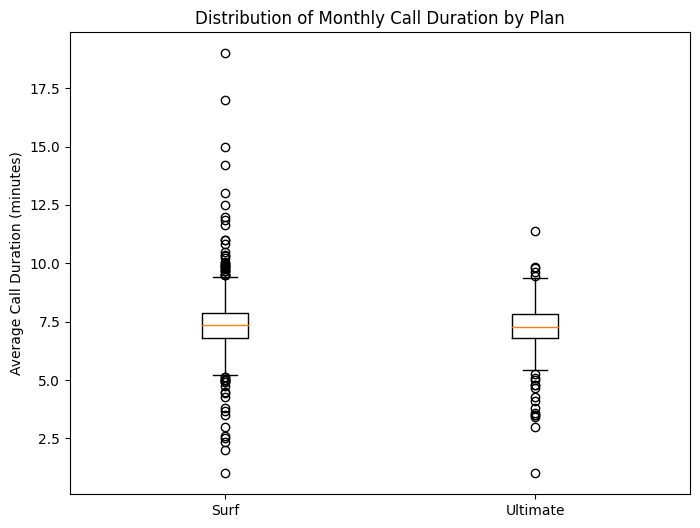

In [27]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.figure(figsize=(8, 6))
plt.boxplot([surf_users['avg_call_duration'].dropna(), 
             ultimate_users['avg_call_duration'].dropna()], 
            labels=['Surf', 'Ultimate'])
plt.ylabel('Average Call Duration (minutes)')
plt.title('Distribution of Monthly Call Duration by Plan')
plt.show()

[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]

Despite the medians being similiar, users on the surf plan have more calling variability (as shown with the orange line)in the middle 50% of users. Furthermore, although both plans have outliers, users on the surf plan have more extreme high outliers, indicating inconsistencies in calling behavior. In contrast, users on the ultimate plan have more consistent/predictable calling behavior.

### Messages

In [28]:
# Create filtered dataset by plan
surf_users = calls_per_month[calls_per_month['plan_name'] == 'surf']
ultimate_users = calls_per_month[calls_per_month['plan_name'] == 'ultimate']

# Compare the number of messages users of each plan tend to send each month

surf_mean = surf_users['total_messages'].mean()
surf_variance = surf_users['total_messages'].var()

ultimate_mean = ultimate_users['total_messages'].mean()
ultimate_variance = ultimate_users['total_messages'].var()

# Compare the standard deviation between plan users
surf_msg_std = surf_users['total_messages'].std()
ultimate_msg_std = ultimate_users['total_messages'].std()


print(f"Surf - Mean: {surf_mean:.3f}, Variance: {surf_variance:.3f}")
print(f"Ultimate - Mean: {ultimate_mean:.3f}, Variance: {ultimate_variance:.3f}")
print("\nMESSAGES:")
print(f"Surf - Std: {surf_msg_std:.3f}")
print(f"Ultimate - Std: {ultimate_msg_std:.3f}")


Surf - Mean: 40.110, Variance: 1091.344
Ultimate - Mean: 46.296, Variance: 1085.183

MESSAGES:
Surf - Std: 33.035
Ultimate - Std: 32.942


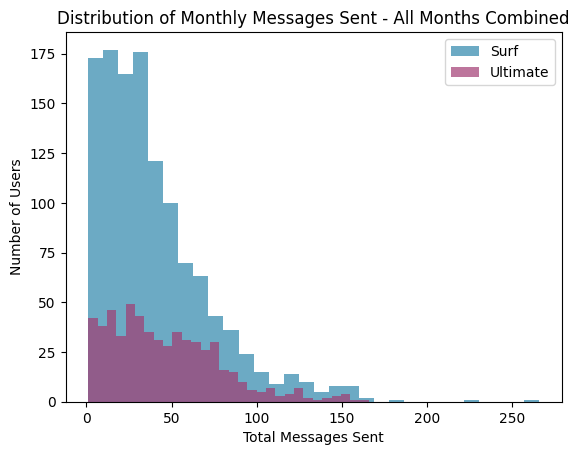

In [29]:
# Histogram
plt.hist(surf_users['total_messages'], bins=30, alpha=0.7, label='Surf', color='#2E86AB')
plt.hist(ultimate_users['total_messages'], bins=30, alpha=0.7, label='Ultimate', color='#A23B72')
plt.xlabel('Total Messages Sent')
plt.ylabel('Number of Users')
plt.title('Distribution of Monthly Messages Sent - All Months Combined')
plt.legend()
plt.show()

[Formulate conclusions on how the users behave in terms of messaging. Is their behaviour different between the plans?]

Although users on the surf plan have a high concentration of users in the 50 message range, there is a stark decline afterwards. In contrast, those on the ultimate plan also have higher concentrations around the 50 message range, but they have more spread across higher usage. Furthermore, users on both plans have similar variability. In other words, surf users are light messengers, compared to those on the ultimate plan.

### Internet

In [30]:
# Create filtered dataset by plan
surf_users = calls_per_month[calls_per_month['plan_name'] == 'surf']
ultimate_users = calls_per_month[calls_per_month['plan_name'] == 'ultimate']

# Compare the amount of internet traffic consumed by users per plan
surf_mean = surf_users['total_volume'].mean()
surf_variance = surf_users['total_volume'].var()

ultimate_mean = ultimate_users['total_volume'].mean()
ultimate_variance = ultimate_users['total_volume'].var()

# Compare te standard deviation for both plans
surf_internet_std = surf_users['total_volume'].std()
ultimate_internet_std = ultimate_users['total_volume'].std()

print(f"Surf - Mean: {surf_mean:.3f}, Variance: {surf_variance:.3f}")
print(f"Ultimate - Mean: {ultimate_mean:.3f}, Variance: {ultimate_variance:.3f}")
print("\nINTERNET:")
print(f"Surf - Std: {surf_internet_std:.3f}")
print(f"Ultimate - Std: {ultimate_internet_std:.3f}")

Surf - Mean: 16717.702, Variance: 62168225.747
Ultimate - Mean: 17238.642, Variance: 61324847.981

INTERNET:
Surf - Std: 7884.683
Ultimate - Std: 7831.018


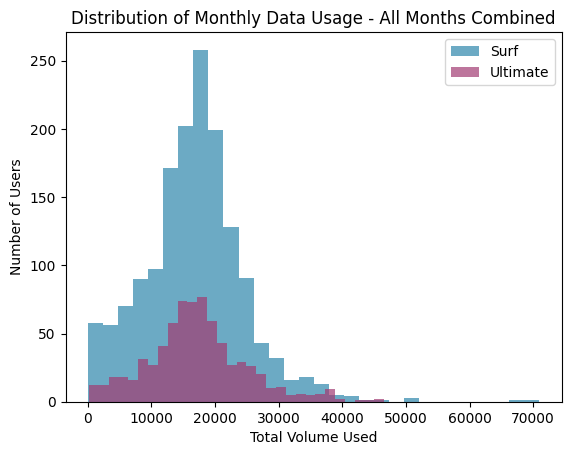

In [31]:
plt.hist(surf_users['total_volume'], bins=30, alpha=0.7, label='Surf', color='#2E86AB')
plt.hist(ultimate_users['total_volume'], bins=30, alpha=0.7, label='Ultimate', color='#A23B72')
plt.xlabel('Total Volume Used')
plt.ylabel('Number of Users')
plt.title('Distribution of Monthly Data Usage - All Months Combined')
plt.legend()
plt.show()

[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

Both plans have similar shapes, with most usage around the 10 to 20k MB range. Users on the ultimate plan tend to have more usage (on or around 25K MB). The standard deviation indicates similar variability between the two plans, with both exhibiting extreme outliers exceeding 60K MB. That said, those on the ultimate plan tend to have higher usage than those on the surf plan.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

In [32]:
# Create filtered dataset by plan
surf_users = calls_per_month[calls_per_month['plan_name'] == 'surf']
ultimate_users = calls_per_month[calls_per_month['plan_name'] == 'ultimate']

# Calculate revenue statistics
surf_revenue_mean = surf_users['total_revenue'].mean()
surf_revenue_var = surf_users['total_revenue'].var()
surf_revenue_std = surf_users['total_revenue'].std()

ultimate_revenue_mean = ultimate_users['total_revenue'].mean()
ultimate_revenue_var = ultimate_users['total_revenue'].var()
ultimate_revenue_std = ultimate_users['total_revenue'].std()

# Display results
print("REVENUE COMPARISON:")
print(f"Surf - Mean: ${surf_revenue_mean:.2f}, Variance: {surf_revenue_var:.2f}, Std: ${surf_revenue_std:.2f}")
print(f"Ultimate - Mean: ${ultimate_revenue_mean:.2f}, Variance: {ultimate_revenue_var:.2f}, Std: ${ultimate_revenue_std:.2f}")



REVENUE COMPARISON:
Surf - Mean: $60.17, Variance: 2864.74, Std: $53.52
Ultimate - Mean: $72.25, Variance: 121.76, Std: $11.03


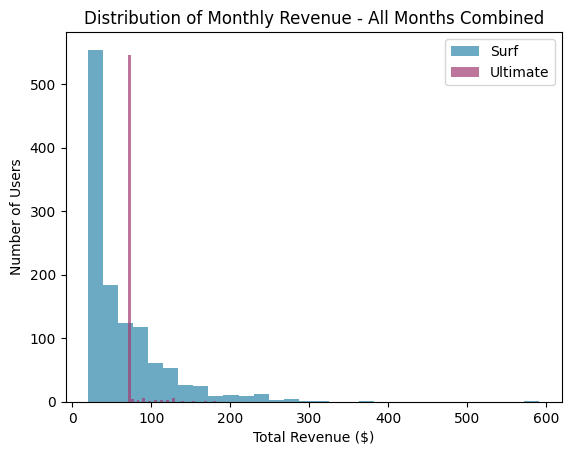

In [33]:
# Histogram
plt.hist(surf_users['total_revenue'], bins=30, alpha=0.7, label='Surf', color='#2E86AB')
plt.hist(ultimate_users['total_revenue'], bins=30, alpha=0.7, label='Ultimate', color='#A23B72')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Number of Users')
plt.title('Distribution of Monthly Revenue - All Months Combined')
plt.legend()
plt.show()

[Formulate conclusions about how the revenue differs between the plans.]

The histogram reveals that users on the ultimate plan have a severe spike, indicating minimal to no revenue changes. However, those on the surf plan have more variability, indicating more revenue gains ranging from $0 to $500.
Furthermore, the standard deviation reveals a stark difference between the two plans as well, with ultimate users around SD = 11 (dollars) and surf users around SD = 53 (dollars).
Hence, those on the ultimate plan provide revenue stability, and those on the surf plan suggest revenue uncertainty due to the inconsistent revenue (i.e., low to high monthly charges).

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

Hypotheses

H₀: The average revenue from Ultimate users is equal to or less than the average revenue from Surf users.

H₁: The average revenue from Ultimate users is greater than the average revenue from Surf users.


In [34]:
# Test the hypotheses
from scipy import stats

# Get revenue data for each plan
surf_revenue = surf_users['total_revenue']
ultimate_revenue = ultimate_users['total_revenue']

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Alpha level: 0.05")

if p_value < 0.05:
    print("Reject the null hypothesis - there is a significant difference in average revenue")
else:
    print("Fail to reject the null hypothesis - no significant difference found")
    

T-statistic: nan
P-value: nan
Alpha level: 0.05
Fail to reject the null hypothesis - no significant difference found


In [35]:
# Check for missing values
print("Surf revenue NaN count:", surf_revenue.isna().sum())
print("Ultimate revenue NaN count:", ultimate_revenue.isna().sum())
print("Surf revenue sample:", surf_revenue.head())
print("Ultimate revenue sample:", ultimate_revenue.head())

Surf revenue NaN count: 379
Ultimate revenue NaN count: 141
Surf revenue sample: 1    20.00
2    20.00
3    90.09
4    60.00
5    60.00
Name: total_revenue, dtype: float64
Ultimate revenue sample: 0     70.0
19    70.0
20    84.0
26    70.0
27    70.0
Name: total_revenue, dtype: float64


In [36]:
# Remove NaN values before testing
surf_revenue_clean = surf_users['total_revenue'].dropna()
ultimate_revenue_clean = ultimate_users['total_revenue'].dropna()

# Check sample sizes after cleaning
print(f"Surf sample size: {len(surf_revenue_clean)}")
print(f"Ultimate sample size: {len(ultimate_revenue_clean)}")

Surf sample size: 1194
Ultimate sample size: 579


In [37]:
# Perform the t-test
t_statistic, p_value = stats.ttest_ind(surf_revenue_clean, ultimate_revenue_clean, equal_var=False)

print(f"Surf sample size: {len(surf_revenue_clean)}")
print(f"Ultimate sample size: {len(ultimate_revenue_clean)}")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Alpha level: 0.05")

if p_value < 0.05:
    print("Reject the null hypothesis - there is a significant difference in average revenue")
else:
    print("Fail to reject the null hypothesis - no significant difference found")
    

Surf sample size: 1194
Ultimate sample size: 579
T-statistic: -7.475
P-value: 0.000000
Alpha level: 0.05
Reject the null hypothesis - there is a significant difference in average revenue


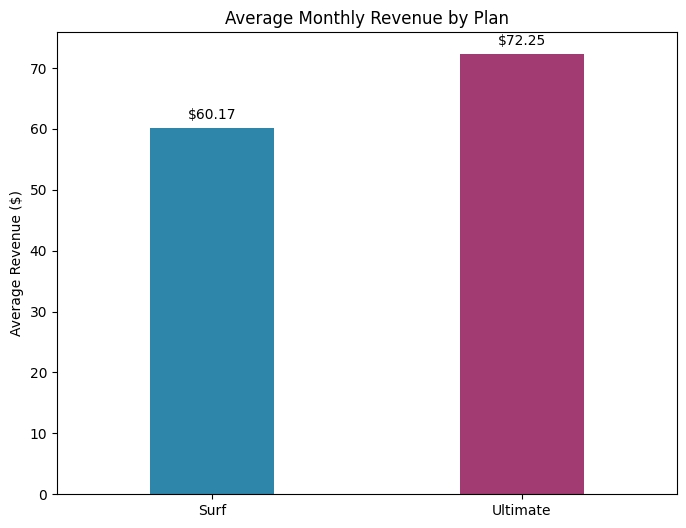

In [38]:
# Data visualization
# Calculate means for the bar chart
surf_mean = surf_revenue_clean.mean()
ultimate_mean = ultimate_revenue_clean.mean()

# Create bar chart
plt.figure(figsize=(8, 6))
plans = ['Surf', 'Ultimate']
means = [surf_mean, ultimate_mean]

plt.bar(plans, means, color=['#2E86AB', '#A23B72'], width=0.4)
plt.ylabel('Average Revenue ($)')
plt.title('Average Monthly Revenue by Plan')

# Add value labels on top of bars
for i, v in enumerate(means):
    plt.text(i, v + 1, f'${v:.2f}', ha='center', va='bottom')

# Adjust x-axis limits to bring bars closer together
plt.xlim(-0.5, 1.5)

plt.show()

This visualization clearly shows the significant revenue gap between the two plans, with Ultimate users earning $12.08 more per month on average than Surf users ($72.25 versus $60.17). The large difference indicates a 20% higher revenue stream from Ultimate customers. This finding, confirmed by statistical testing (p < 0.001), offers strong evidence that Ultimate is the more profitable plan for the company to focus on in advertising efforts. The consistently higher revenue from Ultimate users makes it the obvious choice for maximizing company revenue per customer.

[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

Hypotheses

Ho: There are no differences in average revenue from users in the NY-NJ
area than from users in other regions.
H1: There are differences in average revenue from users in the NY-NJ area than from users in other regions.


In [39]:
# Include both upstate NY cities and the main NYC metro area
ny_nj_pattern = 'NY MSA|NJ MSA|New York-Newark-Jersey City, NY-NJ-PA MSA'
ny_nj_mask = users['city'].str.contains(ny_nj_pattern, na=False)

print("All NY-NJ cities:")
print(users[ny_nj_mask]['city'].unique())

# Get updated counts
ny_nj_users_count = ny_nj_mask.sum()
other_users_count = len(users) - ny_nj_users_count
print(f"\nNY-NJ users: {ny_nj_users_count}")
print(f"Other region users: {other_users_count}")

All NY-NJ cities:
['New York-Newark-Jersey City, NY-NJ-PA MSA' 'Buffalo-Cheektowaga, NY MSA'
 'Albany-Schenectady-Troy, NY MSA' 'Rochester, NY MSA']

NY-NJ users: 86
Other region users: 414


In [40]:
# Create NY-NJ indicator in users dataset
users['is_ny_nj'] = users['city'].str.contains(ny_nj_pattern, na=False)

# Merge with calls_per_month to get revenue by region
calls_with_region = calls_per_month.merge(users[['user_id', 'is_ny_nj', 'city']], on='user_id', how='left')

# Filter into two groups for comparison
ny_nj_revenue = calls_with_region[calls_with_region['is_ny_nj'] == True]['total_revenue'].dropna()
other_revenue = calls_with_region[calls_with_region['is_ny_nj'] == False]['total_revenue'].dropna()

print(f"NY-NJ revenue sample size: {len(ny_nj_revenue)}")
print(f"Other regions revenue sample size: {len(other_revenue)}")

NY-NJ revenue sample size: 302
Other regions revenue sample size: 1471


In [41]:
# Hypothesis testing

from scipy import stats

# Perform two-sample t-test (two-tailed)
t_statistic, p_value = stats.ttest_ind(ny_nj_revenue, other_revenue, equal_var=False)

# Calculate descriptive statistics
ny_nj_mean = ny_nj_revenue.mean()
other_mean = other_revenue.mean()

print("REGIONAL REVENUE COMPARISON:")
print(f"NY-NJ mean revenue: ${ny_nj_mean:.2f}")
print(f"Other regions mean revenue: ${other_mean:.2f}")
print(f"Difference: ${ny_nj_mean - other_mean:.2f}")
print(f"\nT-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Alpha level: 0.05")

if p_value < 0.05:
    print("Reject the null hypothesis - there IS a significant difference in average revenue between regions")
else:
    print("Fail to reject the null hypothesis - no significant difference found between regions")
    

REGIONAL REVENUE COMPARISON:
NY-NJ mean revenue: $60.24
Other regions mean revenue: $64.91
Difference: $-4.67

T-statistic: -1.761
P-value: 0.078969
Alpha level: 0.05
Fail to reject the null hypothesis - no significant difference found between regions


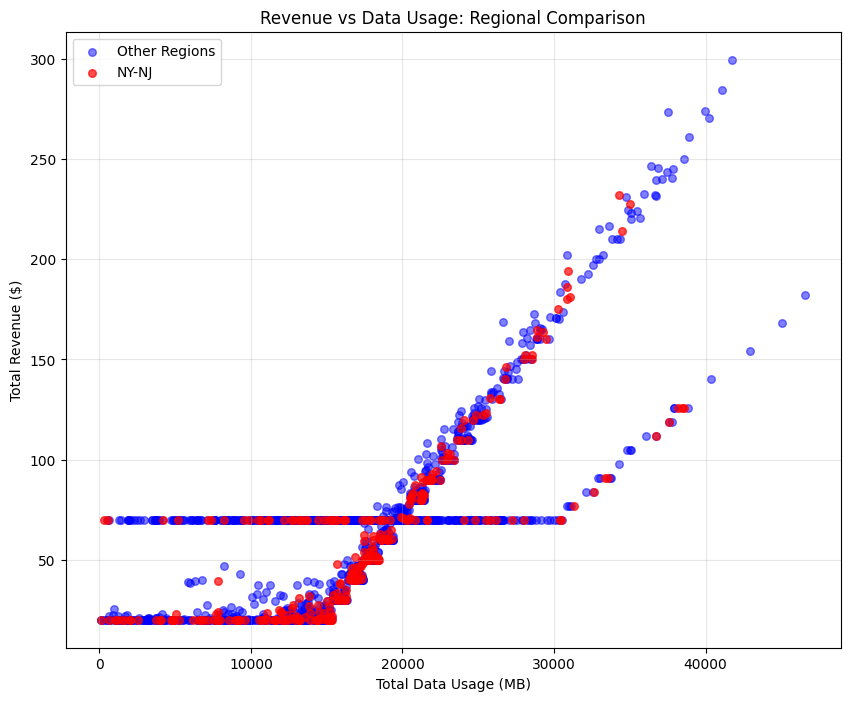

In [42]:
# Data visualization
import numpy as np

plt.figure(figsize=(10, 8))

# Filter out extreme outliers for better visualization
clean_data = calls_with_region.dropna(subset=['total_revenue', 'total_volume'])
clean_data = clean_data[(clean_data['total_revenue'] < 300) & (clean_data['total_volume'] < 50000)]

# Separate the two groups
ny_nj_data = clean_data[clean_data['is_ny_nj'] == True]
other_data = clean_data[clean_data['is_ny_nj'] == False]

# Plot with better separation and transparency
plt.scatter(other_data['total_volume'], other_data['total_revenue'], 
           c='blue', alpha=0.5, label='Other Regions', s=30)
plt.scatter(ny_nj_data['total_volume'], ny_nj_data['total_revenue'], 
           c='red', alpha=0.7, label='NY-NJ', s=30)

plt.xlabel('Total Data Usage (MB)')
plt.ylabel('Total Revenue ($)')
plt.title('Revenue vs Data Usage: Regional Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


This scatterplot reveals two key business insights. First, it visually shows that NY-NJ users (red) and users from other regions (blue) follow identical revenue-to-usage patterns, with both groups similarly distributed across all data usage levels. This confirms the statistical finding that geographic location does not significantly affect revenue generation (p = 0.079). Second, the plot highlights the core difference in business models between plans: the horizontal line at about $70 represents Ultimate users who pay steady monthly fees regardless of their usage, while the upward curve indicates how Surf users incur increasing overage charges as their data consumption grows. The overlapping red and blue points across both patterns confirm that regional targeting would not yield any meaningful revenue advantage.

## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]

Behavioral Decisions

Overall, behavioral insights showed that call duration patterns were almost identical between plans (both averaging around 7.3 minutes). However, Ultimate users sent more messages (46 vs. 40 per month) and used more data (17,239 vs. 16,718 MB). This suggests that the Ultimate plan appeals not only to higher spenders but also to more active digital users.

Methodological Decisions

Missing revenue data (379 Surf NaN values, 141 Ultimate) were handled by removing incomplete records. The Welch's t-test was used for revenue comparison due to significantly different variances between plans. For demographic data, upstate NY cities were combined with the NYC metro area to ensure proper regional representation.

Revenue Stability Implications

Data analysis revealed that the Ultimate plan's low variance ($11 standard deviation) provides predictable cash flow, whereas Surf's high variance ($53 standard deviation) results in revenue uncertainty, despite similar average usage patterns. Statistical testing confirmed a significant revenue difference between plans (p < 0.001), while regional analysis showed no significant difference in revenue patterns (p = 0.079).

Recommendation

I recommend that this company allocate its advertising budget to the Ultimate plan, given its higher average revenue ($72 vs. $60) and greater revenue predictability. Geographic targeting does not provide any revenue advantage based on statistical analysis.


---

## Conclusions & Business Recommendations

### Primary Finding: Ultimate Plan Outperforms Surf by 20%

Our comprehensive analysis of 500 customer accounts reveals a clear winner:

**Ultimate Plan generates significantly higher revenue:**
- Average monthly revenue: **$72.25** vs $60.17 (Surf)
- Statistical significance: **p < 0.001** (highly confident result)
- Difference magnitude: **+$12.08 per customer per month** (20% increase)

### Revenue Stability Analysis

**Ultimate Plan shows lower variance:**
- More predictable revenue streams
- Fewer extreme overage situations
- Better financial forecasting capability

**Surf Plan characteristics:**
- Higher revenue variance
- More unpredictable overage charges
- Entry-level positioning

### Geographic Analysis: No Regional Targeting Needed

**Finding**: NY-NJ area shows no significant revenue difference vs other markets (p = 0.079)

**Implication**: 
- Plan performance is consistent nationwide
- No need for region-specific advertising campaigns
- National campaigns will be cost-effective
- Resources saved from regional customization can be reinvested

### 2018 Advertising Budget Allocation

**Recommended Split:**

```
Ultimate Plan:  70% of advertising budget
  - Focus on value proposition (included features)
  - Target moderate-to-heavy data users
  - Emphasize cost predictability

Surf Plan:      30% of advertising budget  
  - Entry-level customer acquisition
  - Budget-conscious segment
  - Pathway to Ultimate upgrade
```

### Customer Migration Strategy

**Upgrade Campaigns:**

1. **Identify Surf customers with consistent overages**
   - Calculate monthly overage costs
   - Show savings opportunity with Ultimate

2. **Targeted upgrade offers**
   - "You're paying $X in overages - Ultimate saves you money"
   - Personalized communication based on usage patterns

3. **Success metrics**
   - Track Surf → Ultimate conversion rate
   - Monitor revenue per user improvement
   - Measure customer satisfaction with upgraded plans

### Expected Business Impact

**Revenue Optimization:**
- Shifting customer mix toward Ultimate increases ARPU by 20%
- More stable, predictable revenue streams
- Better financial planning capability

**Cost Efficiency:**
- National campaigns eliminate regional customization costs
- Focus on single high-value product simplifies messaging
- Data-driven budget allocation maximizes ROI

### Implementation Roadmap

**Q1 2018:**
- Launch Ultimate-focused national campaign (70% budget)
- Maintain Surf campaigns for acquisition (30% budget)
- Begin Surf → Ultimate upgrade outreach

**Q2 2018:**
- Analyze campaign performance by plan
- Adjust budget allocation based on conversion data
- Expand successful upgrade messaging

**Success Metrics to Track:**
- Average revenue per user (target: +15-20%)
- Plan mix ratio (target: 60% Ultimate, 40% Surf)
- Customer acquisition cost by plan
- Upgrade conversion rate (Surf → Ultimate)

---

**Statistical analysis completed by Danisha L. Thomas, PhD**  
**GitHub**: [drdanishalthomas](https://github.com/drdanishalthomas)  
**LinkedIn**: [/in/drdlthomas](https://linkedin.com/in/drdlthomas)
